# [Recurrent Neural Network for Multivariate Time Series with Missing Values](https://www.nature.com/articles/s41598-018-24271-9.pdf)

## 1. low-level GRU implementation [reference](https://gist.github.com/kmjjacobs/eab1e840aecf0ac232cc8370a9be9093)

In [49]:
import tensorflow as tf
import numpy as np

def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

class GRU():
    
    def __init__(self, input_dimensions,hidden_size,time_steps, dtype=tf.float32):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.time_steps = time_steps
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_holder = tf.placeholder(dtype=dtype, shape=(None, self.time_steps, self.input_dimensions), name='input')
        
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_holder, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=dtype, shape=(self.input_dimensions, self.hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of update gate
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        # Definition of reset gate
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of candidate actvation
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the actual next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t
        

## 2. GRU implementation test ([data produce](https://github.com/MorvanZhou/tutorials/blob/master/tensorflowTUT/tf20_RNN2.2/full_code.py))

In [50]:
import matplotlib.pyplot as plt
%matplotlib qt5

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = 12
LR = 0.006

tf.reset_default_graph()

def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

model = GRU(input_dimensions=INPUT_SIZE , hidden_size=HIDDEN_SIZE, time_steps=TIME_STEPS )
output_holder = tf.placeholder(tf.float32,[None,TIME_STEPS,OUTPUT_SIZE])
w_out = weight_variable([HIDDEN_SIZE,OUTPUT_SIZE])
b_out = bias_variable([OUTPUT_SIZE])

h = tf.reshape(model.h_t,(-1,HIDDEN_SIZE))
predict = tf.matmul(h,w_out)+b_out
predict = tf.reshape(predict,(-1,TIME_STEPS,OUTPUT_SIZE))
loss = tf.reduce_mean((predict-output_holder)**2)
train_Op = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


plt.ion()
plt.show()
for i in range(300):
        seq, res, xs = get_batch()
        
        feed_dict = {
                    model.input_holder: seq,
                    output_holder: res
            }


        _, loss_, pred = sess.run(
            [train_Op, loss,predict],
            feed_dict=feed_dict)
        if i%20==0:
            print('loss: %g'%(loss_))
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

loss: 0.505794
loss: 0.499066
loss: 0.452047
loss: 0.424813
loss: 0.408263
loss: 0.374123
loss: 0.397297
loss: 0.397086
loss: 0.377148
loss: 0.368662
loss: 0.365565
loss: 0.312797
loss: 0.230635
loss: 0.177786
loss: 0.16004


## 3. Literature model implementation with little modification for fitting transportation problem

### 3.1 Data preparation

In [213]:
import numpy as np
import tensorflow as tf
import scipy.io
import tensorly as ts
import os
import matplotlib.pyplot as plt
os.chdir("G:/jupyter/Guangzhou-data-set")
tensor = scipy.io.loadmat('tensor.mat')
tensor = tensor['tensor']
tensor = np.array(tensor)
print(tensor.shape)
tensor = tensor.reshape(214,-1)
print(tensor.shape)
# tensor[tensor==0]=np.mean(tensor)

(214, 61, 144)
(214, 8784)


### 3.2 Model implementation

In [214]:

def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

class GRU_D():
    def __init__(self,network_size, input_len, hidden_size,output_len,dtype=tf.float32):
        
        self.input_holder = tf.placeholder(tf.float32,[None,input_len*network_size],name='input')
        self.mask_holder = tf.placeholder(tf.float32,[None,input_len*network_size],name='mask')
        self.base_observation_holder = tf.placeholder(tf.float32,[None,input_len*network_size],name='base') # last observation in literature modified
        self.decay_affector = tf.placeholder(tf.float32,[None,input_len*network_size],name='decay')
        self.emprical_holder = tf.placeholder(tf.float32,[None,input_len*network_size],name='emprical') # modified
        self.output_holder = tf.placeholder(tf.float32,[None,output_len*network_size],name='output')
        self.input_len = input_len
        self.output_len = output_len
                
        self.input_dimensions = network_size
        self.hidden_size = hidden_size
        self.time_steps = input_len
        
        h_size = 32
        
        # impute input
        mask = tf.eye(self.input_len*self.input_dimensions)
        ## diagonal to make variable indepent from each other
        wd1 = tf.multiply(mask,weight_variable([self.input_len*self.input_dimensions,self.input_len*self.input_dimensions]))
        bd1 = bias_variable([self.input_len*self.input_dimensions])
        response=tf.matmul(self.decay_affector,wd1)+bd1
        self.input_decay = tf.exp(-tf.math.maximum(response,0.))
        
        self.input_mask = tf.multiply(self.mask_holder,self.input_holder)+ tf.multiply(1-self.mask_holder,(tf.multiply(self.input_decay,self.base_observation_holder) + tf.multiply(1-self.input_decay, self.emprical_holder)))
        
        # impute feature
        self.wd2 = weight_variable([ self.input_dimensions,self.hidden_size])
        self.bd2 = bias_variable([ self.hidden_size])
      
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
          
        self.input_holder_ = tf.reshape(self.input_mask,(-1,self.time_steps,self.input_dimensions))
        self.decay_affector1 = tf.reshape(self.decay_affector,(-1,self.time_steps,self.input_dimensions))
        self.mask1 = tf.reshape(self.mask_holder,(-1,self.time_steps,self.input_dimensions))
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_holder_, [1, 0, 2], name='x_t')
        self.decay_affector11 = tf.transpose(self.decay_affector1, [1, 0, 2], name='d_t')
        self.mask11 = tf.transpose(self.mask1, [1, 0, 2], name='m_t')
        
        self.wdmk1 = weight_variable([ self.input_dimensions,self.hidden_size])
         
        self.wdmk2 = weight_variable([ self.input_dimensions,self.hidden_size])
        
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=dtype, shape=(self.input_dimensions, self.hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, (self.x_t, self.decay_affector11,self.mask11), initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        
    def train(self,):
        w_out = weight_variable([self.hidden_size*1,self.output_len*self.input_dimensions])
        b_out = bias_variable([self.output_len*self.input_dimensions])

        self.pred = (tf.matmul(self.h_t[:,-1,:],w_out)+b_out)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.pred,self.output_holder))
        
        self.trainOp = tf.train.AdadeltaOptimizer(learning_rate=0.1).minimize(self.loss)
    
    def forward_pass(self, h_tm1, c_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        (x_t, d_t, m_t) = c_t
        # Definitions of update gate
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz + tf.matmul(m_t, self.wdmk1))
        # Definition of reset gate
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br + tf.matmul(m_t, self.wdmk2))
        
        # Definition of candidate actvation
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # feature decay
        response2 =tf.matmul(d_t,self.wd2)+self.bd2
        self.feature_decay = tf.exp(-tf.math.maximum(response2,0.))
#         self.feature_decay = tf.exp(-tf.maximize(tf.matmul(d_t,self.wd2)+self.bd2,0))
        
        h_proposal_ = tf.multiply(self.feature_decay, h_proposal)
        
        # Compute the actual next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal_)
        
        return h_t  
        

### 3.3 Test

In [215]:
def sample(data,input_len=6,output_len=1, mr=0.2):
    input_set=[]
    mask_set=[]
    output_set=[]
    emprical_set=[] # mean set
    base_set = []
    decay_affector_set = []
    
    empriacal = np.mean(data,axis=1)
    empriacal_full =np.array([empriacal,]*input_len)
    
    for i in range(data.shape[1]-output_len):
        origin_input = data[:,i:i+input_len]
        condition = np.random.binomial(1, 1-mr, np.shape(origin_input)[0]*np.shape(origin_input)[1])
        condition = np.reshape(condition,(np.shape(origin_input)[0],np.shape(origin_input)[1]))
        mask = np.where(condition<1,0.,1.)
        origin_output = data[:,i+input_len:i+input_len+output_len]
        
        sparse_input = np.transpose(np.multiply(origin_input, mask)).reshape(-1,)
        mask = np.transpose(mask).reshape(-1,)
        
        origin_input_T = np.transpose(origin_input).reshape(-1,)
        t = origin_input_T.shape[0]-1
        
        base = []
        decay_affector = []
        while t>=0:
            for r in range(data.shape[0]):
                tt = t-r
                k = 0
                while sparse_input[tt]<=0 and tt>=0:
                    tt-=data.shape[0]
                    k+=1
                if origin_input_T[tt]<=0:
                    base.append(-1)
                else:
                    base.append(origin_input_T[tt])
                decay_affector.append(k)
                
            t-=data.shape[0]
            
        base = np.array(base[::-1]).reshape(-1,)
        decay_affector = np.array(decay_affector[::-1]).reshape(-1,)
        
        input_set.append(sparse_input)
        mask_set.append(mask)
        output_set.append(np.transpose(origin_output).reshape(-1,))
        emprical_set.append(empriacal_full.reshape(-1,))
        base_set.append(base)
        decay_affector_set.append(decay_affector)
        
    return input_set, output_set, mask_set, emprical_set, base_set, decay_affector_set

def generate_batch(input_set, output_set, mask_set, emprical_set, base_set, decay_affector_set,batch_size=32, epoch=0):
    input_batch = []
    output_batch = []
    mask_batch = []
    emprical_batch = []
    base_batch = []
    decay_affector_batch=[]
    
    for i in range(batch_size):
        input_batch.append(input_set[epoch])
        output_batch.append(output_set[epoch])
        mask_batch.append(mask_set[epoch])
        emprical_batch.append(emprical_set[epoch])
        base_batch.append(base_set[epoch])
        decay_affector_batch.append(decay_affector_set[epoch])
        epoch+=1
    return input_batch, output_batch, mask_batch, emprical_batch, base_batch, decay_affector_batch

In [216]:
input_len=6

input_set, output_set, mask_set, emprical_set, base_set, decay_affector_set       = sample(tensor[:,:-144*5],input_len=input_len)
input_set_, output_set_, mask_set_, emprical_set_, base_set_, decay_affector_set_ = sample(tensor[:,-144*5:],input_len=input_len)

tf.reset_default_graph()
sess = tf.Session()
model = GRU_D(network_size=214, input_len=input_len,  hidden_size=160, output_len=1)
model.train()
sess.run(tf.global_variables_initializer())

max_episode = 500
batch_size = 32


for i in range(max_episode):
    loss_set=[]
#     input_set, output_set, mask_set, emprical_set, base_set, decay_affector_set=sample(tensor[:,:-144*5],input_len=input_len)
    for j in range(int(tensor.shape[0]/(batch_size+1))):
        input_batch, output_batch, mask_batch, emprical_batch, base_batch, decay_affector_batch = generate_batch(input_set, output_set, mask_set, emprical_set, base_set, decay_affector_set,epoch=j)
        l,_ = sess.run([model.loss,model.trainOp], feed_dict={model.input_holder:input_batch, model.mask_holder:mask_batch, model.base_observation_holder:base_batch,
                                              model.decay_affector:decay_affector_batch, 
                                              model.emprical_holder:emprical_batch,
                                              model.output_holder:output_batch})
        loss_set.append(l)
    
    input_batch_, output_batch_, mask_batch_, emprical_batch_, base_batch_, decay_affector_batch_ = generate_batch(input_set_, output_set_, mask_set_, emprical_set_, base_set_, decay_affector_set_,epoch=0, batch_size=144*5-6)
    l,p = sess.run([model.loss, model.pred], feed_dict={model.decay_affector:decay_affector_batch_, 
                                                        model.mask_holder:mask_batch_, 
                                                        model.base_observation_holder:base_batch_,
                                                        model.input_holder:input_batch_, 
                                                        model.emprical_holder:emprical_batch_,
                                                        model.output_holder:output_batch_})
    if i%10==0 and i>0:
        print('episode:%d, train RMSE: %g, test RMSE: %g'%(i,np.sqrt(np.mean(np.array(loss_set))),np.sqrt(l)))

episode:10, train RMSE: 46.6724, test RMSE: 38.459
episode:20, train RMSE: 45.5715, test RMSE: 37.4631
episode:30, train RMSE: 44.3745, test RMSE: 36.4136
episode:40, train RMSE: 43.186, test RMSE: 35.3579
episode:50, train RMSE: 42.0214, test RMSE: 34.3133
episode:60, train RMSE: 40.8815, test RMSE: 33.2921
episode:70, train RMSE: 39.7632, test RMSE: 32.2869
episode:80, train RMSE: 38.6639, test RMSE: 31.3027
episode:90, train RMSE: 37.5835, test RMSE: 30.3421
episode:100, train RMSE: 36.5212, test RMSE: 29.4027
episode:110, train RMSE: 35.4765, test RMSE: 28.484
episode:120, train RMSE: 34.4493, test RMSE: 27.5864
episode:130, train RMSE: 33.4395, test RMSE: 26.7095
episode:140, train RMSE: 32.4469, test RMSE: 25.8533
episode:150, train RMSE: 31.4715, test RMSE: 25.018
episode:160, train RMSE: 30.5131, test RMSE: 24.2035
episode:170, train RMSE: 29.5715, test RMSE: 23.4102
episode:180, train RMSE: 28.6466, test RMSE: 22.6381
episode:190, train RMSE: 27.7383, test RMSE: 21.8874
episod

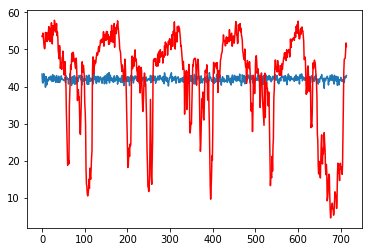

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline
road = 1
real = np.array(output_batch_).reshape(-1,214)[:,road]
pred = p[:,road]

plt.plot(pred)
plt.plot(real,'r')
plt.show()